<a href="https://colab.research.google.com/github/ryandipp/employees-attrition-analytics-prediction/blob/main/Employees_Attrition_Analytics_Ryandi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data cleaning

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import warnings
import io
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
pd.options.display.float_format='{:.2f}'.format

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
uploaded = files.upload()

Saving W1_general_data.csv to W1_general_data.csv


In [3]:
raw = pd.read_csv(io.BytesIO(uploaded['W1_general_data.csv']))

making self function for data checking

In [4]:
def check(df):
  for c in df.columns:
    uni = df[c].unique()
    na = df[c].isna().sum()
    unic = df[c].value_counts().to_dict()
    dup = df[c].duplicated().sum()
    print(f'{c}')
    print(f'UNIQUE VALUES: {sorted(uni)}')
    print(f'DICT: {unic}')
    print(f'DUPLI: {dup}')
    print(f'NULLS: {na} \n')


In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

In [6]:
check(raw)

Age
UNIQUE VALUES: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
DICT: {35: 234, 34: 231, 31: 207, 36: 207, 29: 204, 32: 183, 30: 180, 38: 174, 33: 174, 40: 171, 37: 150, 28: 144, 27: 144, 42: 138, 39: 126, 45: 123, 41: 120, 26: 117, 46: 99, 44: 99, 43: 96, 50: 90, 24: 78, 25: 78, 49: 72, 47: 72, 55: 66, 48: 57, 51: 57, 53: 57, 52: 54, 54: 54, 22: 48, 58: 42, 23: 42, 56: 42, 21: 39, 20: 33, 59: 30, 19: 27, 18: 24, 60: 15, 57: 12}
DUPLI: 4367
NULLS: 0 

Attrition
UNIQUE VALUES: ['No', 'Yes']
DICT: {'No': 3699, 'Yes': 711}
DUPLI: 4408
NULLS: 0 

BusinessTravel
UNIQUE VALUES: ['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']
DICT: {'Travel_Rarely': 3129, 'Travel_Frequently': 831, 'Non-Travel': 450}
DUPLI: 4407
NULLS: 0 

Department
UNIQUE VALUES: ['Human Resources', 'Research & Development', 'Sales']
DICT: {'Research & Development': 2883, 'Sales': 1338, 'Human 

##Handling missing values

In [7]:
raw_fill=raw.copy()

In [8]:
raw_fill['NumCompaniesWorked'] = np.where((raw_fill['TotalWorkingYears'] - raw_fill['YearsAtCompany'] == 1),
                                     0,
                                     raw_fill['NumCompaniesWorked'])
raw_fill['NumCompaniesWorked'] = np.where((raw_fill['TotalWorkingYears'] == raw_fill['YearsAtCompany']),
                                     1,
                                     raw_fill['NumCompaniesWorked'])

In [9]:
raw_fill['TotalWorkingYears'] = np.where((raw_fill['NumCompaniesWorked']==0),
                                     (raw_fill['YearsAtCompany']+1),
                                     raw_fill['TotalWorkingYears'])
raw_fill['TotalWorkingYears'] = np.where((raw_fill['NumCompaniesWorked']==1),
                                     raw_fill['YearsAtCompany'],
                                     raw_fill['TotalWorkingYears'])

In [10]:
raw_fill = raw_fill.dropna(subset= ['NumCompaniesWorked','TotalWorkingYears'])

In [11]:
raw_fill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4396 non-null   int64  
 1   Attrition                4396 non-null   object 
 2   BusinessTravel           4396 non-null   object 
 3   Department               4396 non-null   object 
 4   DistanceFromHome         4396 non-null   int64  
 5   Education                4396 non-null   int64  
 6   EducationField           4396 non-null   object 
 7   EmployeeCount            4396 non-null   int64  
 8   EmployeeID               4396 non-null   int64  
 9   Gender                   4396 non-null   object 
 10  JobLevel                 4396 non-null   int64  
 11  JobRole                  4396 non-null   object 
 12  MaritalStatus            4396 non-null   object 
 13  MonthlyIncome            4396 non-null   int64  
 14  NumCompaniesWorked      

dropping irrelevant fields/columns

In [12]:
df0 = raw_fill[['Attrition','EmployeeID','Age','BusinessTravel',
       'DistanceFromHome', 'Education',
       'Gender', 'JobLevel', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion']]

In [13]:
df0.head(3)

,Attrition,EmployeeID,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,No,1,51,Travel_Rarely,6,2,Female,1,Married,131160,1.00,11,0,1.00,6,1,0
1,Yes,2,31,Travel_Frequently,10,1,Female,1,Single,41890,0.00,23,1,6.00,3,5,1
2,No,3,32,Travel_Frequently,17,4,Male,4,Married,193280,1.00,15,3,5.00,2,5,0


#EDA

In [14]:
eda=raw_fill[['Attrition', 'Age', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'Gender',
       'JobLevel', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion']]

In [15]:
eda['Attrition'] = pd.get_dummies(eda['Attrition'], drop_first=True)

In [16]:
eda.head(3)

,Attrition,Age,BusinessTravel,Department,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,0,51,Travel_Rarely,Sales,6,2,Female,1,Married,131160,1.00,11,1.00,6,1,0
1,1,31,Travel_Frequently,Research & Development,10,1,Female,1,Single,41890,0.00,23,6.00,3,5,1
2,0,32,Travel_Frequently,Research & Development,17,4,Male,4,Married,193280,1.00,15,5.00,2,5,0


##EDA gender

In [17]:
eda_gender=eda.groupby('Gender').agg(
    att_rate = ('Attrition', lambda x: x.sum()/x.count()*100))

In [18]:
eda_gender=eda_gender.reset_index(drop=False)
eda_gender

,Gender,att_rate
0,Female,15.28
1,Male,16.62


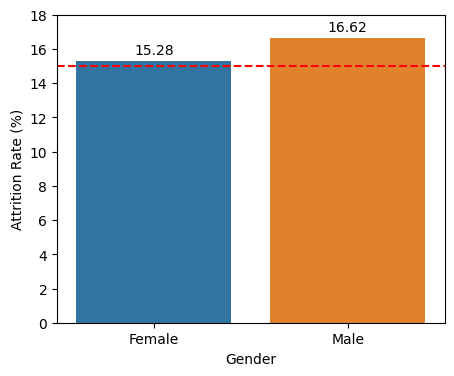

In [19]:
plt.figure(figsize=(5,4))
sns.barplot(data=eda_gender, x=eda_gender['Gender'], y=eda_gender['att_rate'])
plt.axhline(y=15, color='red', linestyle='dashed')
plt.ylabel('Attrition Rate (%)')
plt.yticks(range(0,20,2))

for i,r in eda_gender.iterrows():
    plt.annotate(f"{r['att_rate']:.2f}", (i,r['att_rate']),
                 xytext=(0,5), textcoords='offset points', ha='center')

## hypothesis testing 1:<br>
attrition among gender | H0: attrition rate between genders are the same | alpha 0.05

In [20]:
MaleXY = eda[['Attrition']][eda['Gender']=='Male']
FemaleXX = eda[['Attrition']][eda['Gender']=='Female']

In [21]:
Genderttest, Genderpvalue=stats.ttest_ind(MaleXY, FemaleXX, equal_var=False)

In [22]:
print('T-test:',Genderttest[0].round(2))
print('P-value:',Genderpvalue[0].round(2))

T-test: 1.19
P-value: 0.24


##EDA job level

In [106]:
eda_dept_job = eda.groupby(['Department','JobLevel']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()

In [108]:
eda_dept_job = eda_dept_job.pivot(index='JobLevel', columns='Department', values='att_rate')
eda_dept_job

Department,Human Resources,Research & Development,Sales
JobLevel,,,
1,15.79,18.25,8.90
2,23.94,16.05,20.52
3,50.00,11.06,17.55
4,50.00,14.06,15.79
5,50.00,8.06,9.52


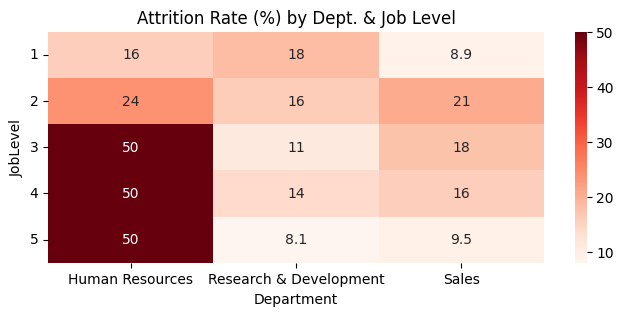

In [109]:
plt.figure(figsize = (8,3))
sns.heatmap(data=eda_dept_job, cmap='Reds', annot=True)
plt.title('Attrition Rate (%) by Dept. & Job Level')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

##EDA years in company

In [28]:
eda_co_years = eda.groupby('YearsAtCompany').agg(
    att = ('Attrition', 'sum'),
    total_group = ('YearsAtCompany','count')
).reset_index()

In [29]:
tenure_bin=[0,4,11,35,41]
eda_co_years['tenure_group'] = pd.cut(eda_co_years['YearsAtCompany'],bins=tenure_bin,labels=['onboarding','settled','dedicated','retiring'],right=False)

In [30]:
eda_tenuregroup=eda_co_years.groupby('tenure_group').agg(
    att=('att','sum'),
    total_group=('total_group','sum')).reset_index()

In [31]:
eda_tenuregroup['att_rate']=eda_tenuregroup['att']/eda_tenuregroup['total_group']*100
eda_tenuregroup

,tenure_group,att,total_group,att_rate
0,onboarding,365,1405,25.98
1,settled,282,2253,12.52
2,dedicated,57,726,7.85
3,retiring,3,12,25.00


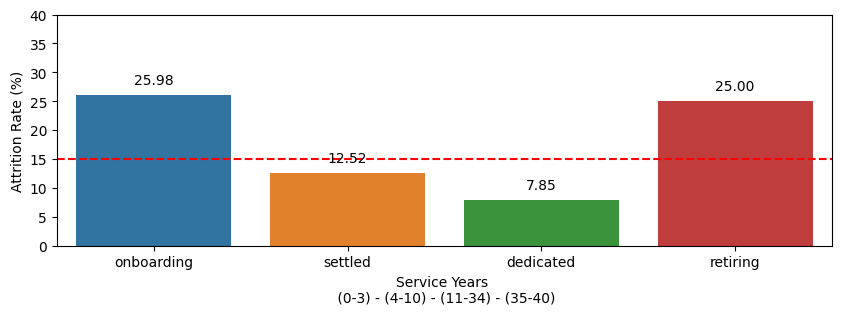

In [32]:
plt.figure(figsize=(10,3))
sns.barplot(data=eda_tenuregroup,
            x='tenure_group',
            y='att_rate')
plt.axhline(y=15, color='red', linestyle='dashed')

for i,r in eda_tenuregroup.iterrows():
    plt.annotate(f"{r['att_rate']:.2f}", (i, r['att_rate']),
                 xytext=(0, 8), textcoords='offset points', ha='center')

plt.xlabel(f"Service Years \n (0-3) - (4-10) - (11-34) - (35-40)")
plt.ylabel('Attrition Rate (%)')
plt.yticks(range(0,45,5))

plt.show()

##EDA career development

In [110]:
eda_career=eda[['YearsAtCompany','TrainingTimesLastYear','YearsSinceLastPromotion','Attrition']]
eda_career.head(3)

,YearsAtCompany,TrainingTimesLastYear,YearsSinceLastPromotion,Attrition
0,1,6,0,0
1,5,3,1,1
2,5,2,0,0


In [111]:
tenure_bin=[0,4,11,35,41]
eda_career['YearsAtCompany'] = pd.cut(eda_career['YearsAtCompany'],bins=tenure_bin,labels=['onboarding','settled','dedicated','retiring'],right=False)

In [112]:
promo_bin=[0,3,6,11,16]
eda_career['YearsSinceLastPromotion']=pd.cut(eda_career['YearsSinceLastPromotion'], bins=promo_bin, labels=['0-2Y','3-5Y','6-10Y','11-16Y'], right=False)

In [113]:
eda_career.head(9)

,YearsAtCompany,TrainingTimesLastYear,YearsSinceLastPromotion,Attrition
0,onboarding,6,0-2Y,0
1,settled,3,0-2Y,1
2,settled,2,0-2Y,0
3,settled,5,6-10Y,0
4,settled,2,0-2Y,0
5,settled,5,6-10Y,0
6,onboarding,2,0-2Y,1
7,onboarding,2,0-2Y,0
8,settled,2,6-10Y,0


In [114]:
eda4a=eda_career.groupby(['YearsAtCompany','TrainingTimesLastYear']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).fillna(0).reset_index()

In [115]:
eda4a=eda4a.pivot(index='YearsAtCompany', columns='TrainingTimesLastYear', values='att_rate')

In [116]:
eda4a

TrainingTimesLastYear,0,1,2,3,4,5,6
YearsAtCompany,,,,,,,
onboarding,6.25,12.50,27.27,28.60,23.20,27.73,20.00
settled,25.93,15.62,13.17,12.89,10.59,7.58,2.86
dedicated,18.18,8.33,9.76,8.14,0.00,7.69,0.00
retiring,0.00,0.00,33.33,0.00,0.00,0.00,0.00


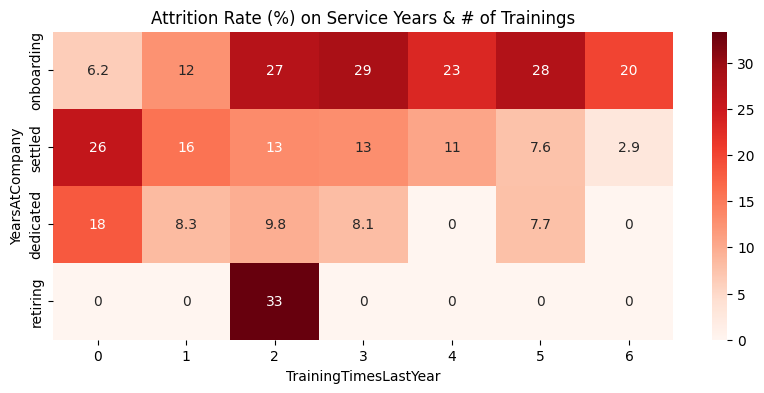

In [117]:
plt.figure(figsize=(10,4))
sns.heatmap(data=eda4a, cmap='Reds', annot=True)
plt.title('Attrition Rate (%) on Service Years & # of Trainings')
plt.show()

In [118]:
eda4b=eda_career.groupby('YearsAtCompany').agg(
    minTraining=('TrainingTimesLastYear','min'),
    maxTraining=('TrainingTimesLastYear','max'),
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()
eda4b

,YearsAtCompany,minTraining,maxTraining,att_rate
0,onboarding,0,6,25.98
1,settled,0,6,12.52
2,dedicated,0,6,7.85
3,retiring,2,6,25.00


In [119]:
eda4c=eda_career.groupby(['YearsAtCompany','YearsSinceLastPromotion']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index().fillna(0)
eda4c

,YearsAtCompany,YearsSinceLastPromotion,att_rate
0,onboarding,0-2Y,25.98
1,onboarding,3-5Y,0.00
2,onboarding,6-10Y,0.00
3,onboarding,11-16Y,0.00
4,settled,0-2Y,10.92
5,settled,3-5Y,13.98
6,settled,6-10Y,19.35
7,settled,11-16Y,0.00
8,dedicated,0-2Y,3.12
9,dedicated,3-5Y,6.41


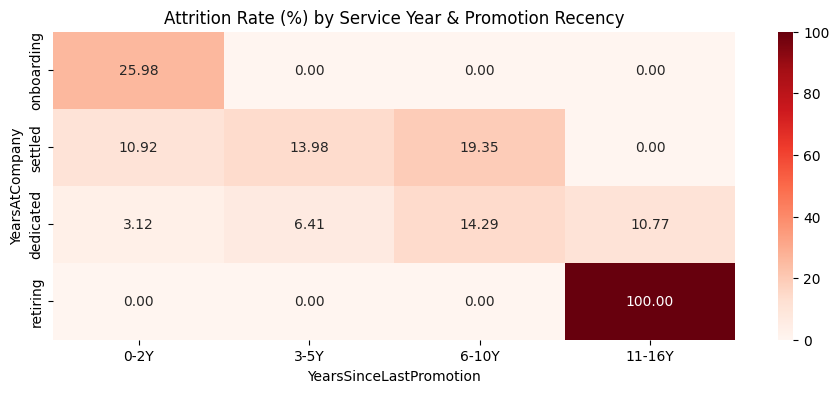

In [120]:
eda4c = eda4c.pivot_table(index='YearsAtCompany', columns='YearsSinceLastPromotion', values='att_rate')

plt.figure(figsize=(11, 4))
sns.heatmap(eda4c, annot=True, cmap='Reds', fmt='.2f')
plt.title('Attrition Rate (%) by Service Year & Promotion Recency' )
plt.xlabel('YearsSinceLastPromotion')
plt.ylabel('YearsAtCompany')
plt.show()

##EDA salary

In [44]:
eda_salary=eda.copy()

In [45]:
eda_salary=eda_salary[['MonthlyIncome','PercentSalaryHike','JobLevel','Attrition']]
eda_salary.head(3)

,MonthlyIncome,PercentSalaryHike,JobLevel,Attrition
0,131160,11,1,0
1,41890,23,1,1
2,193280,15,4,0


In [46]:
MeanSal1=eda_salary[eda_salary['JobLevel']==1]['MonthlyIncome'].mean()
MeanSal2=eda_salary[eda_salary['JobLevel']==2]['MonthlyIncome'].mean()
MeanSal3=eda_salary[eda_salary['JobLevel']==3]['MonthlyIncome'].mean()
MeanSal4=eda_salary[eda_salary['JobLevel']==4]['MonthlyIncome'].mean()
MeanSal5=eda_salary[eda_salary['JobLevel']==5]['MonthlyIncome'].mean()

In [47]:
eda_salary['LevelMeanSalary']=eda_salary['JobLevel'].apply(
    lambda x: MeanSal1 if x ==1
    else MeanSal2 if x ==2
    else MeanSal3 if x ==3
    else MeanSal4 if x ==4
    else MeanSal5)


In [48]:
eda_salary['VSMeanLevel'] = np.where(
    (eda_salary['MonthlyIncome'] > eda_salary['LevelMeanSalary']), 'Above Mean', 'Below Mean')

In [49]:
eda_salary.head(3)

,MonthlyIncome,PercentSalaryHike,JobLevel,Attrition,LevelMeanSalary,VSMeanLevel
0,131160,11,1,0,62677.37,Above Mean
1,41890,23,1,1,62677.37,Below Mean
2,193280,15,4,0,77940.75,Above Mean


In [50]:
eda_salary.groupby('JobLevel').agg(
    MeanSalary=('MonthlyIncome','mean')).reset_index()

,JobLevel,MeanSalary
0,1,62677.37
1,2,65548.08
2,3,63450.41
3,4,77940.75
4,5,64620.83


In [51]:
eda_salaryGroup=eda_salary.groupby(['JobLevel','VSMeanLevel']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()
eda_salaryGroup

,JobLevel,VSMeanLevel,att_rate
0,1,Above Mean,12.68
1,1,Below Mean,16.84
2,2,Above Mean,20.38
3,2,Below Mean,16.51
4,3,Above Mean,10.04
5,3,Below Mean,17.43
6,4,Above Mean,11.11
7,4,Below Mean,18.57
8,5,Above Mean,3.39
9,5,Below Mean,15.75


In [121]:
eda_salaryGroup=eda_salaryGroup.pivot(index='VSMeanLevel', columns='JobLevel', values='att_rate')
eda_salaryGroup

JobLevel,1,2,3,4,5
VSMeanLevel,,,,,
Above Mean,12.68,20.38,10.04,11.11,3.39
Below Mean,16.84,16.51,17.43,18.57,15.75


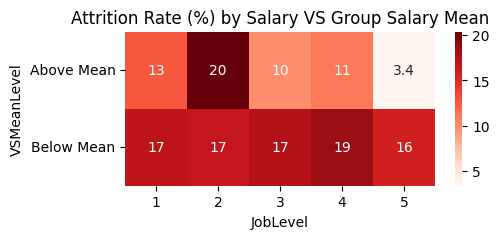

In [122]:
plt.figure(figsize = (5,2))
sns.heatmap(data=eda_salaryGroup, cmap='Reds', annot=True)
plt.title('Attrition Rate (%) by Salary VS Group Salary Mean')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

In [54]:
eda_salary['PercentSalaryHike'] = pd.cut(eda_salary['PercentSalaryHike'], bins=[9,14,20,26], labels=['fair','good','excellent'], right=True)

In [55]:
eda_salary.head(3)

,MonthlyIncome,PercentSalaryHike,JobLevel,Attrition,LevelMeanSalary,VSMeanLevel
0,131160,fair,1,0,62677.37,Above Mean
1,41890,excellent,1,1,62677.37,Below Mean
2,193280,good,4,0,77940.75,Above Mean


In [123]:
eda_raise=eda_salary.groupby(['JobLevel','PercentSalaryHike']).agg(
    att_rate=('Attrition', lambda x: x.sum()/x.count()*100)).reset_index()

In [124]:
eda_raise=eda_raise.pivot(index='PercentSalaryHike', columns='JobLevel', values='att_rate')

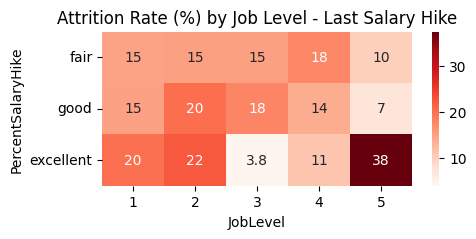

In [125]:
plt.figure(figsize = (5,2))
sns.heatmap(data=eda_raise, cmap='Reds', annot=True)
plt.title('Attrition Rate (%) by Job Level - Last Salary Hike')
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.show()

## hypothesis testing 2:<br>
monthly salary vs mean


H0: there is no attrition rate difference between below mean salary group & above mean salary groups

In [59]:
df1 = df0.copy()
df1['Attrition'] = pd.get_dummies(df1['Attrition'], drop_first = True)

In [60]:
t_test_salary = df1[['MonthlyIncome','Attrition']]

In [61]:
mean_salary = t_test_salary['MonthlyIncome'].mean()
print(f'{mean_salary:.2f}')

65029.02


In [62]:
belowMean = t_test_salary[['Attrition']][t_test_salary['MonthlyIncome'] < mean_salary]
aboveMean = t_test_salary[['Attrition']][t_test_salary['MonthlyIncome'] > mean_salary]

In [63]:
# Perform a two-sample t-test
t_stat, p_value = stats.ttest_ind(aboveMean, belowMean, equal_var=False)

In [64]:
print(f't-stat = {t_stat[0]:.2f}')
print(f'p-value = {p_value[0]:.2f}')
if p_value[0] < 0.05:
  print('REJECT H0')
else:
  print('ACCEPT H0')

t-stat = -2.23
p-value = 0.03
REJECT H0


#ML preprocessing & training

In [65]:
from sklearn.preprocessing import OrdinalEncoder
oe = OrdinalEncoder()

In [66]:
df1_encoded = df1.copy()

In [67]:
df1_object = df1.select_dtypes(include = 'object')
df1_encoded[df1_object.columns] = oe.fit_transform(df1[df1_object.columns])

In [68]:
##  0: Divorced
##  1: Married
##  2: Single
df1_encoded.head(3)

,Attrition,EmployeeID,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,0,1,51,2.00,6,2,0.00,1,1.00,131160,1.00,11,0,1.00,6,1,0
1,1,2,31,1.00,10,1,0.00,1,2.00,41890,0.00,23,1,6.00,3,5,1
2,0,3,32,1.00,17,4,1.00,4,1.00,193280,1.00,15,3,5.00,2,5,0


In [69]:
x1 = df1_encoded.iloc[:,2:]
y1 = df1_encoded.iloc[:,:1]

In [70]:
x1.info()
print('\n')
y1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4396 entries, 0 to 4409
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4396 non-null   int64  
 1   BusinessTravel           4396 non-null   float64
 2   DistanceFromHome         4396 non-null   int64  
 3   Education                4396 non-null   int64  
 4   Gender                   4396 non-null   float64
 5   JobLevel                 4396 non-null   int64  
 6   MaritalStatus            4396 non-null   float64
 7   MonthlyIncome            4396 non-null   int64  
 8   NumCompaniesWorked       4396 non-null   float64
 9   PercentSalaryHike        4396 non-null   int64  
 10  StockOptionLevel         4396 non-null   int64  
 11  TotalWorkingYears        4396 non-null   float64
 12  TrainingTimesLastYear    4396 non-null   int64  
 13  YearsAtCompany           4396 non-null   int64  
 14  YearsSinceLastPromotion 

##p-values of x variables

In [71]:
X1_in = sm.add_constant(x1)
scores = sm.Logit(y1,X1_in).fit()
print(scores.summary())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 4396
Model:                          Logit   Df Residuals:                     4380
Method:                           MLE   Df Model:                           15
Date:                Tue, 04 Jul 2023   Pseudo R-squ.:                     inf
Time:                        03:59:21   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.4017      0.382     -1.052      0.293      -1.150       0

In [72]:
scores.pvalues

const                     0.29
Age                       0.00
BusinessTravel            1.00
DistanceFromHome          0.73
Education                 0.14
Gender                    0.36
JobLevel                  0.49
MaritalStatus             0.00
MonthlyIncome             0.07
NumCompaniesWorked        0.00
PercentSalaryHike         0.31
StockOptionLevel          0.23
TotalWorkingYears         0.00
TrainingTimesLastYear     0.00
YearsAtCompany            0.00
YearsSinceLastPromotion   0.00
dtype: float64

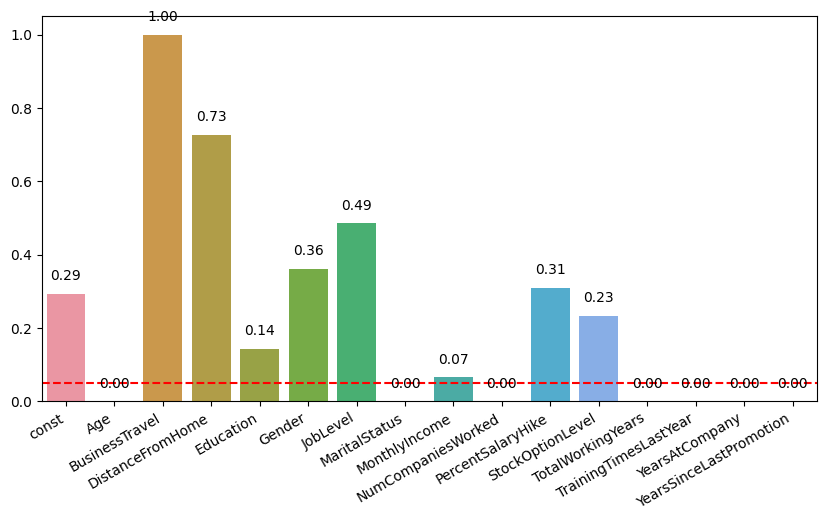

Significant Variables with low p-values
Age                       0.00
MaritalStatus             0.00
NumCompaniesWorked        0.00
TotalWorkingYears         0.00
TrainingTimesLastYear     0.00
YearsAtCompany            0.00
YearsSinceLastPromotion   0.00
dtype: float64


In [73]:
plt.figure(figsize=(10, 5))
sns.barplot(x=scores.pvalues.index, y=scores.pvalues)
plt.axhline(y=0.05, color='red', linestyle='--')

for index, value in enumerate(scores.pvalues):
    plt.annotate(f"{value:.2f}", (index, value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xticks(rotation=30, ha='right')

plt.show()
print('Significant Variables with low p-values')
print(scores.pvalues[scores.pvalues < 0.05])


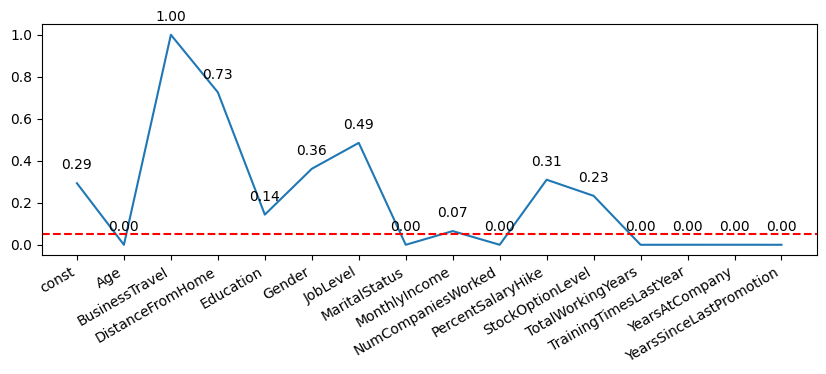

Significant Variables with low p-values
Age                       0.00
MaritalStatus             0.00
NumCompaniesWorked        0.00
TotalWorkingYears         0.00
TrainingTimesLastYear     0.00
YearsAtCompany            0.00
YearsSinceLastPromotion   0.00
dtype: float64


In [74]:
plt.figure(figsize=(10, 3))
sns.lineplot(data=scores.pvalues, x=scores.pvalues.index, y=scores.pvalues)
plt.axhline(y=0.05, color='red', linestyle='--')

for index, value in enumerate(scores.pvalues):
    plt.annotate(f"{value:.2f}", (index, value), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xticks(rotation=30, ha='right')

plt.show()
print('Significant Variables with low p-values')
print(scores.pvalues[scores.pvalues<0.05])

In [75]:
to_scale = scores.pvalues[scores.pvalues<0.05].index

from sklearn.feature_selection import SelectKBest, chi2
<br>fs1 = SelectKBest(chi2, k = 14)
<br>x1best = fs1.fit_transform(x1,y1)
<br>x1best = pd.DataFrame(data = x1best, columns = fs1.get_feature_names_out())

##scaling variables



In [76]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [77]:
x1_scaled = x1[to_scale]
x1_scaled[x1_scaled.columns]= scaler.fit_transform(x1_scaled[to_scale])

In [78]:
x1_scaled

,Age,MaritalStatus,NumCompaniesWorked,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,1.54,-0.13,-0.66,-1.32,2.48,-0.98,-0.68
1,-0.65,1.24,-1.05,-0.68,0.16,-0.33,-0.37
2,-0.54,-0.13,-0.66,-0.81,-0.62,-0.33,-0.68
3,0.12,-0.13,0.14,0.22,1.71,0.16,1.49
4,-0.54,1.24,0.53,-0.29,-0.62,-0.17,-0.68
...,...,...,...,...,...,...,...
4405,0.56,1.24,0.14,-0.16,1.71,-0.65,-0.68
4406,-0.87,-1.50,-0.26,-0.16,-0.62,-0.65,-0.68
4407,-1.30,-0.13,-1.05,-0.81,0.93,-0.49,-0.37
4408,0.56,-1.50,-1.05,-0.16,-0.62,0.32,1.49


##spliting-traininging-testing

In [79]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(random_state=42)

In [80]:
x1_tr, x1_ts, y1_tr, y1_ts = train_test_split(x1_scaled, y1, train_size = 0.8, random_state=42)

In [81]:
log.fit(x1_tr,y1_tr)
print(f'Score: {log.score(x1_tr,y1_tr):.2f}')

Score: 0.84


##calculating x variables' odds

In [82]:
x1_coef=log.coef_[0]
x1_summ = pd.DataFrame({'Variables':x1_tr.columns.values,
                        'Coeff':x1_coef,
                        'Odds':np.exp(x1_coef)}
                        )

In [83]:
print(f'Intercept:{log.intercept_[0]:.2f}')
x1_summ.sort_values('Coeff', ascending=False, inplace=True)
x1_summ

Intercept:-1.91


,Variables,Coeff,Odds
1,MaritalStatus,0.47,1.59
6,YearsSinceLastPromotion,0.37,1.44
2,NumCompaniesWorked,0.26,1.29
4,TrainingTimesLastYear,-0.18,0.83
0,Age,-0.21,0.81
5,YearsAtCompany,-0.35,0.70
3,TotalWorkingYears,-0.51,0.60


#New Syntethic Data

In [84]:
n_sample = 2000
age = np.random.randint(27,37,n_sample)
travel = np.random.choice(['rare','frequent','none'],n_sample)
dist = np.random.randint(1,20,n_sample)
education = np.random.randint(2,4,n_sample)
gender = np.random.choice(['male','female'],n_sample)
joblevel = np.random.randint(2,4,n_sample)
marital = np.random.choice(['single','married','divorced'],n_sample)
inco = np.random.randint(50000,175000,n_sample)
numco = np.random.randint(2,6,n_sample)
hike = np.random.randint(10,20,n_sample)
stokop = np.random.randint(0,2,n_sample)
wyear = np.random.randint(5,17,n_sample)
yeartrain = np.random.randint(0,7,n_sample)
coyear = np.random.randint(0,10,n_sample)

In [85]:
lastpromo = np.random.randint(0,5,n_sample)

In [86]:
new_data=pd.DataFrame([age,travel,dist,education,gender,joblevel,marital,inco,numco,hike,stokop,wyear,yeartrain,coyear,lastpromo]).transpose()
new_data.columns = x1.columns
new_data.head()

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,31,frequent,18,3,female,2,single,120580,4,13,1,9,2,6,4
1,32,frequent,18,3,male,3,single,51104,4,16,1,9,6,4,0
2,34,none,8,3,female,2,married,86348,3,10,1,9,1,7,2
3,31,rare,1,2,male,3,divorced,174247,5,11,0,12,5,0,0
4,32,rare,15,3,male,2,divorced,72551,3,12,0,15,5,5,0


##making new data more sensical

condition must be met: Total Working Years >= Years At Company >= Years Last Promotion

In [87]:
new_data=new_data[(new_data['YearsAtCompany']<=new_data['TotalWorkingYears']) & (new_data['YearsSinceLastPromotion']<=new_data['YearsAtCompany'])]

In [88]:
new_int = new_data[['Age', 'DistanceFromHome', 'Education',
       'JobLevel',  'MonthlyIncome', 'NumCompaniesWorked',
       'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion']].astype(int)

In [89]:
new_data[new_int.columns]=new_int

In [90]:
oe_new = OrdinalEncoder()
new_obj = new_data.select_dtypes(include=object)
new_obj[new_obj.columns] = oe_new.fit_transform(new_obj)

In [91]:
new_data[new_obj.columns] = new_obj

In [92]:
new_data.head(3)

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,31,0.00,18,3,0.00,2,2.00,120580,4,13,1,9,2,6,4
1,32,0.00,18,3,1.00,3,2.00,51104,4,16,1,9,6,4,0
2,34,1.00,8,3,0.00,2,1.00,86348,3,10,1,9,1,7,2


In [93]:
x_new=new_data.copy()

In [94]:
x_new=x_new[log.feature_names_in_]

In [95]:
scaler_new=StandardScaler()
x_new[x_new.columns]=scaler_new.fit_transform(x_new)

In [96]:
x_new.head()

,Age,MaritalStatus,NumCompaniesWorked,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion
0,-0.16,1.23,0.45,-0.62,-0.47,0.36,1.58
1,0.19,1.23,0.45,-0.62,1.56,-0.46,-1.25
2,0.88,-0.01,-0.46,-0.62,-0.98,0.77,0.16
3,-0.16,-1.24,1.35,0.32,1.05,-2.11,-1.25
4,0.19,-1.24,-0.46,1.26,1.05,-0.05,-1.25


##predicting new data

In [97]:
att=log.predict(x_new)
att_predict=log.predict_proba(x_new)

In [98]:
new_data_att=new_data.copy()
new_data_att['AttritionProba']=att_predict[:,1]
new_data_att['Attrition']=att

In [99]:
employees_to_watch= new_data_att[new_data_att['AttritionProba'] > 0.5].shape[0]
print(f"n Employees to WATCH: {employees_to_watch} out of {len(new_data)}")

n Employees to WATCH: 19 out of 1427


In [100]:
watch_list=new_data_att[new_data_att['AttritionProba'] > 0.5]

In [101]:
watch_list.AttritionProba.mean().round(2)

0.57

In [102]:
new_data_att.AttritionProba.mean().round(2)

0.16

In [103]:
watch_list.head(3)

,Age,BusinessTravel,DistanceFromHome,Education,Gender,JobLevel,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,AttritionProba,Attrition
141,33,0.00,2,3,1.00,2,2.00,70366,5,12,1,5,0,5,4,0.67,1
249,30,2.00,8,2,0.00,3,2.00,111110,4,13,1,5,2,5,3,0.56,1
435,27,0.00,3,2,1.00,2,2.00,75679,4,10,1,5,6,2,1,0.51,1


In [104]:
watch_list.index

Int64Index([ 141,  249,  435,  712,  750,  786,  829,  861, 1031, 1032, 1155,
            1247, 1411, 1480, 1652, 1671, 1824, 1902, 1985],
           dtype='int64')

In [105]:
x1_summ

,Variables,Coeff,Odds
1,MaritalStatus,0.47,1.59
6,YearsSinceLastPromotion,0.37,1.44
2,NumCompaniesWorked,0.26,1.29
4,TrainingTimesLastYear,-0.18,0.83
0,Age,-0.21,0.81
5,YearsAtCompany,-0.35,0.70
3,TotalWorkingYears,-0.51,0.60
